We have 3 different datasets:
1. **Station**:
2. **Trip**:
3. **Weather**:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import sin, cos, sqrt, atan2, radians
from scipy.spatial.distance import pdist

import plotly
import chart_studio.plotly as py
import plotly.express as px
from plotly import graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode(connected=True)

from helpers.helpers_data import *
from helpers.helpers_func import *
from helpers.tokens import *

# Station

In [2]:
station = pd.read_csv("data/station_data.csv", index_col = 0)
station.shape

(76, 5)

In [3]:
{85: 23, 87: 49, 88: 69, 89: 72, 90: 72}

{85: 23, 87: 49, 88: 69, 89: 72, 90: 72}

In [4]:
station = station.drop_duplicates("Name")
all_stations_index = station.index
station.head()

,Name,Lat,Long,Dock Count,City
Id,,,,,
2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
6,San Pedro Square,37.336721,-121.894074,15,San Jose


In [5]:
# station.tail(50)

In [6]:
all_stations_index

Int64Index([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 21, 22, 23,
            24, 25, 86, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41,
            42, 45, 46, 47, 48, 49, 50, 51, 39, 54, 55, 56, 57, 58, 59, 60, 61,
            62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 80,
            82, 83, 84],
           dtype='int64', name='Id')

In [7]:
station[station["City"] == "Palo Alto"]

,Name,Lat,Long,Dock Count,City
Id,,,,,
34,Palo Alto Caltrain Station,37.443988,-122.164759,23,Palo Alto
35,University and Emerson,37.444521,-122.163093,11,Palo Alto
36,California Ave Caltrain Station,37.429082,-122.142805,15,Palo Alto
37,Cowper at University,37.448598,-122.159504,11,Palo Alto
38,Park at Olive,37.425684,-122.137777,15,Palo Alto


In [8]:
# Sanity Check
station.isnull().sum()

Name          0
Lat           0
Long          0
Dock Count    0
City          0
dtype: int64

In [9]:
summary_station = pd.DataFrame()
summary_station["Count"] = station.groupby("City")["Name"].count()
summary_station["Total Docking Station"] = station.groupby("City")["Dock Count"].sum()

In [10]:
summary_station

,Count,Total Docking Station
City,,
Mountain View,7,117
Palo Alto,5,75
Redwood City,8,130
San Francisco,35,665
San Jose,16,264


## Distances

In [11]:
cities

['Mountain View', 'Palo Alto', 'Redwood City', 'San Francisco', 'San Jose']

In [12]:
def diff(arr1, arr2):
    res = np.empty((len(arr1), len(arr2)))
    for i,x in enumerate(arr1):
        for j,y in enumerate(arr2):
            res[i,j] = y-x
            
    return res

In [13]:
def get_city_distance(df, flag):
    # approximate radius of earth in km
    R = 6373.0
    
    if flag == 'stations':
        index_df = df.index
        avg = np.radians(df[['Long', 'Lat']].to_numpy())
    else: # flag == 'cities'
        index_df = cities
        avg = np.radians(df.groupby("City")[['Long', 'Lat']].mean()).to_numpy()
    
    dlon = diff(avg[:,0], avg[:,0])
    dlat = diff(avg[:,1], avg[:,1])

    a =  np.sin(dlat / 2)**2 + np.cos(avg[:,1]) * np.cos(avg[:,1]) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c

    return pd.DataFrame(distance, index=index_df, columns=index_df)


In [14]:
distances_cities = get_city_distance(station, 'cities')
distances_cities

,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose
Mountain View,0.000000,7.445874,15.759707,51.569743,18.647388
Palo Alto,7.448386,0.000000,8.316640,44.552001,25.795830
Redwood City,15.770971,8.319778,0.000000,36.899949,33.938050
San Francisco,51.647263,44.602306,36.926287,0.000000,67.480554
San Jose,18.634557,25.767553,33.886575,67.298834,0.000000


In [15]:
distances_stations = get_city_distance(station, 'stations')
distances_stations

Id,2,3,4,5,6,7,8,9,10,11,...,72,73,74,75,76,77,80,82,83,84
Id,,,,,,,,,,,,,,,,,,,,,
2,0.000000,1.137438,0.770933,0.781765,1.033928,1.388112,1.411606,2.204882,1.560721,1.581551,...,67.316293,68.502363,67.404864,67.426613,67.346820,67.386108,2.567591,68.141483,34.555668,1.544617
3,1.137453,0.000000,0.638997,0.381743,0.807369,0.388998,0.284666,2.070126,0.764858,0.647324,...,67.993703,69.156541,68.051830,68.080635,68.011192,68.043406,2.851286,68.789913,35.471472,1.460881
4,0.770960,0.639016,0.000000,0.323368,0.312686,0.704216,0.908009,1.641168,0.795140,0.844142,...,67.371910,68.538468,67.434929,67.462552,67.391425,67.424782,2.281084,68.172789,34.835618,0.973870
5,0.781782,0.381747,0.323365,0.000000,0.595225,0.613579,0.666416,1.931929,0.861953,0.831781,...,67.684013,68.852550,67.749593,67.776658,67.704674,67.738622,2.604066,68.487331,35.109661,1.276037
6,1.033970,0.807389,0.312687,0.595226,0.000000,0.709543,1.031155,1.338295,0.630461,0.749906,...,67.197586,68.357579,67.252063,67.281631,67.213395,67.244771,2.045144,67.990317,34.747438,0.681621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,67.563218,68.227526,67.605021,67.920252,67.424999,68.088739,68.457039,66.388871,67.787127,67.991190,...,1.481882,1.139784,0.752508,0.242166,0.519398,0.000000,65.415005,0.991735,36.225473,66.833820
80,2.567606,2.851511,2.281183,2.604199,2.045254,2.671284,3.053882,1.064611,2.368176,2.570694,...,65.206290,66.355350,65.246711,65.279308,65.215760,65.243899,0.000000,65.985601,32.995325,1.416669
82,68.320070,68.975620,68.354583,68.670516,68.172122,68.833384,69.203519,67.127768,68.529266,68.733550,...,2.283612,0.561009,0.747636,0.820996,1.408010,0.991735,66.158278,0.000000,37.137881,67.577669


In [16]:
def get_top_k_nearest_stations(df, k):
    
    data=df.columns.values[np.argsort(df.values, axis=1)]
    cols = ["#{}".format(n) for n in np.arange(1, k+1)]
    
    return pd.DataFrame(data[:, 1:k+1], index= df.index, columns=cols)

In [17]:
get_top_k_nearest_stations(distances_stations, 5)

,#1,#2,#3,#4,#5
Id,,,,,
2,14,4,5,6,3
3,8,5,7,12,4
4,6,5,14,3,7
5,4,3,6,7,14
6,4,13,5,10,84
...,...,...,...,...,...
77,75,47,63,56,76
80,9,84,13,6,14
82,42,48,41,46,45


## GeoMapping of the Stations

In [18]:
def get_scatterbox(df, city, colors):
    tmp = go.Scattermapbox(
                lat=df['Lat'],
                lon=df['Long'],
                mode='markers+text',
                marker=dict(
                    size=10,
                    color=colors[city],
                ),

                textfont=dict(
                    size=9
                ),
                textposition="bottom center",
                text=list(df.index),
                name=city
            )
    return tmp

def plot_stations(df, specific_cities):
    mapbox_access_token = map_token
    
    data = []
    if specific_cities == "All":
        lat = np.mean(df['Lat'])
        long = np.mean(df['Long'])
    else:
        lat = []
        long = []
        
    df_groups = df.groupby("City")
    for group in df_groups:
        sub_df = group[1]
        if isinstance(specific_cities, list):
            if group[0] in specific_cities:
                tmp = get_scatterbox(sub_df, group[0], colors)
                lat += sub_df['Lat'].to_list()
                long += sub_df['Long'].to_list()
                data.append(tmp)
        else:
            tmp = get_scatterbox(sub_df, group[0], colors)
            data.append(tmp)
        
    layout = go.Layout(
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            center=dict(
                lat=np.mean(lat),
                lon=np.mean(long)
            ),
            pitch=0,
            zoom=9
        ),
        title='Stations locations within the 5 Areas',
        autosize=False,
        width=900,
        height=800,
        margin=go.layout.Margin(
            l=100,
            r=100,
            b=100,
            t=100,
            pad=4
        ),
        showlegend=True,
        legend = dict(orientation="h")
    )

    fig = dict(data=data, layout=layout)

    offline.iplot(fig)

In [19]:
# plot_stations(station, "All")

# Trip

In [20]:
trip = pd.read_csv("data/trip_data.csv")
trip.shape

(354152, 6)

In [21]:
trip.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,31/08/2015 23:26,50,31/08/2015 23:39,70,Subscriber
1,913459,31/08/2015 23:11,31,31/08/2015 23:28,27,Subscriber
2,913455,31/08/2015 23:13,47,31/08/2015 23:18,64,Subscriber
3,913454,31/08/2015 23:10,10,31/08/2015 23:17,8,Subscriber
4,913453,31/08/2015 23:09,51,31/08/2015 23:22,60,Customer


## Some Cleaning...

Applying the ID's change that occur during the recording period

In [22]:
trip["Start Station"].unique()

array([50, 31, 47, 10, 51, 68, 60, 56, 67, 76, 77, 55, 88, 35, 87, 70, 28,
       74, 90, 61, 32, 63, 57, 64, 54, 65, 45, 66, 75, 59, 42, 48, 41, 82,
       36, 22, 37, 39, 80,  2, 62, 71, 58,  4, 26,  5,  7, 34, 29, 46, 27,
        6, 73, 86, 38, 11,  8, 84,  9, 12, 30, 33, 83, 16, 14, 13,  3, 21,
       24, 85, 89, 69, 72, 49, 23, 25])

In [23]:
trip["Start Station"] = trip["Start Station"].replace({85: 23, 87: 49, 88: 69, 89: 72, 90: 72})
trip["End Station"] = trip["End Station"].replace({85: 23, 87: 49, 88: 69, 89: 72, 90: 72})

In [24]:
trip["End Station"].unique()

array([70, 27, 64,  8, 60, 74, 55, 66, 77, 73, 82, 69, 65, 37, 76, 32, 54,
       61, 57, 56, 71, 28, 50, 49, 58, 39, 41, 67, 42, 72, 33, 75, 63, 29,
       26, 46, 34, 30, 83,  6, 47, 16, 84,  7, 59, 68, 62,  2, 22,  4, 48,
       51, 11, 45,  9, 35, 36, 80, 12, 31,  5, 38, 86, 10, 13, 14,  3, 23,
       21, 24, 25])

Converting Start/End date into a Pandas datetime object

In [25]:
def convert_to_date(x):
    return datetime.strptime(x, '%d/%m/%Y %H:%M')

def convert_to_minutes(x):
    return x.total_seconds() // 60

In [26]:
trip["Start Datetime"] = trip["Start Date"].apply(convert_to_date)
trip["Start Time"] = pd.to_datetime(trip["Start Datetime"].dt.time.astype(str))
trip["Start Date"] = pd.to_datetime(trip["Start Datetime"].dt.date.astype(str))
trip["End Datetime"] = trip["End Date"].apply(convert_to_date)
trip["End Time"] = pd.to_datetime(trip["End Datetime"].dt.time.astype(str))
trip["End Date"] = pd.to_datetime(trip["End Datetime"].dt.date.astype(str))

In [27]:
trip["Start Datetime"].dt.time[0]

datetime.time(23, 26)

In [28]:
trip["Trip Duration"] = trip["End Date"] - trip["Start Date"]
trip["Trip Duration Minutes"] = trip["Trip Duration"].apply(convert_to_minutes)

Adding the associated area to each station

In [29]:
trip["Start Area"] = trip["Start Station"].replace(station["City"].to_dict())
trip["End Area"] = trip["End Station"].replace(station["City"].to_dict())

## Analysis

In [30]:
trip.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,Start Datetime,Start Time,End Datetime,End Time,Trip Duration,Trip Duration Minutes,Start Area,End Area
0,913460,2015-08-31,50,2015-08-31,70,Subscriber,2015-08-31 23:26:00,2020-11-05 23:26:00,2015-08-31 23:39:00,2020-11-05 23:39:00,0 days,0.0,San Francisco,San Francisco
1,913459,2015-08-31,31,2015-08-31,27,Subscriber,2015-08-31 23:11:00,2020-11-05 23:11:00,2015-08-31 23:28:00,2020-11-05 23:28:00,0 days,0.0,Mountain View,Mountain View
2,913455,2015-08-31,47,2015-08-31,64,Subscriber,2015-08-31 23:13:00,2020-11-05 23:13:00,2015-08-31 23:18:00,2020-11-05 23:18:00,0 days,0.0,San Francisco,San Francisco
3,913454,2015-08-31,10,2015-08-31,8,Subscriber,2015-08-31 23:10:00,2020-11-05 23:10:00,2015-08-31 23:17:00,2020-11-05 23:17:00,0 days,0.0,San Jose,San Jose
4,913453,2015-08-31,51,2015-08-31,60,Customer,2015-08-31 23:09:00,2020-11-05 23:09:00,2015-08-31 23:22:00,2020-11-05 23:22:00,0 days,0.0,San Francisco,San Francisco


In [31]:
"This dataset spans from {} to {}".format(trip["Start Date"].min(),trip["End Date"].max())

'This dataset spans from 2014-09-01 00:00:00 to 2015-08-31 00:00:00'

- A good additional info for this dataset would have been to get the ID of the Subcriber (vs Customer). Like that, we could have identified all the trips performed by a specific subscriber, extract habits and probably enhance the accuracy of the prediction we try to make

### Intra-Inter Trip Proportion

In [32]:
intra_inter_trips = pd.pivot_table(trip, index ="Start Area", columns="End Area", values="Trip ID",
               aggfunc=lambda x: len(x.unique()), fill_value= 0.0)
intra_inter_trips

End Area,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose
Start Area,,,,,
Mountain View,9788,198,3,4,6
Palo Alto,182,2851,36,4,0
Redwood City,1,64,1954,0,0
San Francisco,2,0,2,321101,0
San Jose,6,0,0,1,17949


In [33]:
intra_inter_trips["Total"] = intra_inter_trips.sum(axis=1)
intra_inter_trips.loc["Total"] = intra_inter_trips.sum(axis=0)

In [34]:
intra_inter_trips

End Area,Mountain View,Palo Alto,Redwood City,San Francisco,San Jose,Total
Start Area,,,,,,
Mountain View,9788,198,3,4,6,9999
Palo Alto,182,2851,36,4,0,3073
Redwood City,1,64,1954,0,0,2019
San Francisco,2,0,2,321101,0,321105
San Jose,6,0,0,1,17949,17956
Total,9979,3113,1995,321110,17955,354152


### Subscriber Type

In [35]:
trip["Subscriber Type"].value_counts()

Subscriber    310217
Customer       43935
Name: Subscriber Type, dtype: int64

In [36]:
pd.DataFrame(trip.groupby("Start Station")["Subscriber Type"].value_counts())

Subscriber Type
Start Station Subscriber Type                 
2             Subscriber                  4738
              Customer                     230
3             Subscriber                   397
              Customer                     377
4             Subscriber                  1828
...                                        ...
83            Customer                      25
84            Subscriber                   980
              Customer                     140
86            Subscriber                   351
              Customer                      67

[142 rows x 1 columns]

### Station Transistion Matrix & Popularity

In [37]:
def get_top_k_popular_stations(df, k):
    
    data=df.columns.values[np.argsort(-df.values, axis=1)]
    cols = ["#{}".format(n) for n in np.arange(1, k+1)]
    
    return pd.DataFrame(data[:, 0:k], index= df.index, columns=cols)

In [38]:
transition_matrix = []
transition = trip.groupby("Start Station")["End Station"].value_counts()

for x in all_stations_index:
    transition_matrix.append(transition[x].reindex(all_stations_index, fill_value=0).tolist())
    
transition_matrix = pd.DataFrame(transition_matrix, index = all_stations_index, columns=all_stations_index)
popular_stations = get_top_k_popular_stations(transition_matrix, 10)
transition_matrix["Start Total"] = transition_matrix.sum(axis=1)
start_popular_station = transition_matrix["Start Total"][:-1].sort_values(ascending=False).index.tolist()
# If you want to check the correctness of the previous variable, uncomment the next line of code
# transition_matrix["Start Total"][:-1].sort_values(ascending=False)
transition_matrix.loc["End Total"] = transition_matrix.sum(axis=0)
end_popular_station = transition_matrix.loc["End Total"][:-1].sort_values(ascending=False).index.tolist()
# If you want to check the correctness of the previous variable, uncomment the next line of code
# transition_matrix.loc["End Total"][:-1].sort_values(ascending=False)
transition_matrix.head()

Id,2,3,4,5,6,7,8,9,10,11,...,73,74,75,76,77,80,82,83,84,Start Total
Id,,,,,,,,,,,,,,,,,,,,,
2,77,282,1232,268,687,497,99,315,223,461,...,0,0,0,0,0,15,0,0,250,4968
3,209,189,41,25,46,33,8,13,57,43,...,0,0,0,0,0,6,0,0,21,774
4,1214,22,105,12,16,35,26,11,14,17,...,0,0,0,0,0,5,0,0,4,1958
5,307,14,17,29,22,29,17,7,13,21,...,0,0,0,0,0,8,0,0,4,562
6,614,54,11,20,86,36,29,120,46,34,...,0,0,0,0,0,68,0,0,110,1418


In [39]:
popular_stations

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10
Id,,,,,,,,,,
2,4,6,7,11,13,9,3,5,84,10
3,2,3,10,6,11,4,7,12,5,14
4,2,14,12,4,7,8,3,11,16,6
5,2,12,5,7,6,11,4,8,3,10
6,2,9,84,13,6,80,14,3,10,7
...,...,...,...,...,...,...,...,...,...,...
77,64,70,61,50,69,60,73,45,74,82
80,84,6,14,80,9,13,11,2,10,3
82,70,74,56,75,55,69,77,61,41,54


### Time Dimension

In [40]:
tmp = trip[["Start Area", "Start Time"]].value_counts().sort_index()

In [41]:
def vis_trip_density(df, all_cities=True, period="Start", resample=10):
    
    assert period in ["Start", "End", "Both"], "-period- Argument should be either 'Start' or 'End'"
    assert resample > 0, "We cannot resample for a value < 1"
    
#     if period == "Both":
    area = "{} Area".format(period)
    time = "{} Time".format(period)
    
    data = []
    if all_cities:
        tmp = df[time].value_counts().sort_index().resample('{}T'.format(resample)).sum()
        data.append(go.Scatter(x=tmp.index, y=tmp.values, name="All cities"))
    else:
        tmp = df[[area, time]].value_counts().sort_index()
        for city in cities:
            sub = tmp[city].resample('{}T'.format(resample)).sum()
            data.append(go.Scatter(x=sub.index, y=sub.values, name=city))
    
    fig = go.Figure(data=data)
    fig.show()


In [42]:
vis_trip_density(trip, all_cities=False, resample=10)

In [43]:
tmp = trip[["Start Area", "Start Date"]].value_counts().sort_index()

In [46]:
tmp

Start Area     Start Date
Mountain View  2014-09-01    11
               2014-09-02    54
               2014-09-03    43
               2014-09-04    36
               2014-09-05    38
                             ..
San Jose       2015-08-27    61
               2015-08-28    54
               2015-08-29    11
               2015-08-30    33
               2015-08-31    47
Length: 1766, dtype: int64

<AxesSubplot:>

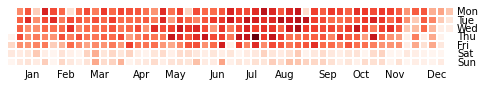

In [47]:
yearplot(tmp["Mountain View"], how=None)

<AxesSubplot:>

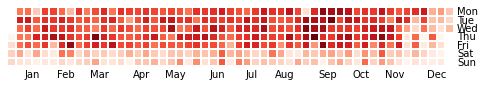

In [48]:
yearplot(tmp["San Jose"], how=None)

# Weather

In [ ]:
weather = pd.read_csv("data/weather_data.csv")
weather.shape

In [ ]:
weather.head()